# Predicting Loan Risk using SparkML

We'll use this notebook to create a machine learning model to predict customer churn. In this notebook we will build the prediction model using the SparkML library.

This notebook walks you through these steps:

- Load and Visualize data set.
- Build a predictive model with SparkML API

## 1.0 Install required packages

There are a couple of Python packages we will use in this notebook. First we make sure the Watson Machine Learning client v3 is removed (its not installed by default) and then install/upgrade the v4 version of the client.

WML Client: https://wml-api-pyclient-dev-v4.mybluemix.net/#repository

### 1.1 Package Installation

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip uninstall watson-machine-learning-client -y | tail -n 1
!pip install --user watson-machine-learning-client-v4==1.0.95 --upgrade | tail -n 1
!pip install --user pyspark==2.3.3 --upgrade | tail -n 1

  Successfully uninstalled watson-machine-learning-client-1.0.378


### 1.2 Package Imports

In [3]:
import pandas as pd
import numpy as np
import json
import os

## 2.0 Load and Clean data

We'll load our data as a pandas data frame.

**<font color='red'><< FOLLOW THE INSTRUCTIONS BELOW TO LOAD THE DATASET >></font>**

* Highlight the cell below by clicking it.
* In the upper right of this notebook, click on `01/00` to open the Data tab, then click on the `Connections` where you should see the Cognos Analytics connection you created earlier.
* Click on `Insert to code` -> `pandas DataFrame`
* The inserted code will create a Cognos Analytics data connector, which we will use to inport/export data back and forth to CA.
* Run the cell

In [4]:
# @hidden_cell
# Place cursor below and use the "Insert to code - pandas DataFrame" option to access the CA connector# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='0d64d9fa-xxxxx-3259a52b3be6', project_access_token='p-8351afxxxxxx7a41796db0ecc9bd1d031dc')
pc = project.project_context

from ca_data_connector import CADataConnector
CADataConnector.connect(project.get_connection(name="ca-connect"))

# in order to access the data, un-comment the following line and edit the path to the data asset:
# data_1 = CADataConnector.read_data(path=".public_folders/data_folder/data_asset")



In [6]:
# Get the German credit data we will use to create our model
# In order to access the data, modify the following line by changing the path and filename to match your data asset in CA.
# NOTE: the file name should be similar to "german_credit_model_data.csv".
df = CADataConnector.read_data(path=".public_folders/cognos-studio-data/german_credit_model_data.csv")
df.head()

,CustomerID,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,4e561ef3-a927-4107-aa12-18ac5772ec63,less_0,6,all_credits_paid_back,car_used,250,less_100,1_to_4,2,male,...,savings_insurance,28,stores,rent,1,skilled,1,none,yes,Risk
1,2663eaee-4f6b-4c84-b816-0b589b6690c8,less_0,14,all_credits_paid_back,appliances,1431,less_100,unemployed,1,female,...,car_other,25,stores,own,1,skilled,1,none,yes,Risk
2,c1324b0f-7b7d-42d5-896b-ee81988e54f3,greater_200,5,credits_paid_to_date,car_used,250,less_100,4_to_7,3,male,...,savings_insurance,42,none,rent,1,skilled,1,none,yes,No Risk
3,c199d5c4-8b0e-4f86-8d36-9b3528ed69b0,less_0,11,all_credits_paid_back,furniture,2016,less_100,less_1,1,female,...,car_other,34,bank,own,1,unemployed,1,none,yes,No Risk
4,c8b70d96-763d-4af5-835a-fc8e1008cfa1,less_0,4,credits_paid_to_date,car_new,250,less_100,unemployed,1,female,...,real_estate,29,none,rent,1,skilled,1,none,yes,No Risk


### 2.1 Drop Some Features
Some columns are data attributes that we will not want to use in the machine learning model. We can drop those columns / features:

- CustomerID feature (column)

In [8]:
#Drop some columns, ignoring errors for missing keys in case we use different data sets.
df = df.drop(columns=['CustomerID'], axis=1, errors='ignore')
df.head(5)

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,less_0,6,all_credits_paid_back,car_used,250,less_100,1_to_4,2,male,none,...,savings_insurance,28,stores,rent,1,skilled,1,none,yes,Risk
1,less_0,14,all_credits_paid_back,appliances,1431,less_100,unemployed,1,female,none,...,car_other,25,stores,own,1,skilled,1,none,yes,Risk
2,greater_200,5,credits_paid_to_date,car_used,250,less_100,4_to_7,3,male,none,...,savings_insurance,42,none,rent,1,skilled,1,none,yes,No Risk
3,less_0,11,all_credits_paid_back,furniture,2016,less_100,less_1,1,female,none,...,car_other,34,bank,own,1,unemployed,1,none,yes,No Risk
4,less_0,4,credits_paid_to_date,car_new,250,less_100,unemployed,1,female,none,...,real_estate,29,none,rent,1,skilled,1,none,yes,No Risk


### 2.2 Examine the data types of the features

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 21 columns):
CheckingStatus              4900 non-null object
LoanDuration                4900 non-null int64
CreditHistory               4900 non-null object
LoanPurpose                 4900 non-null object
LoanAmount                  4900 non-null int64
ExistingSavings             4900 non-null object
EmploymentDuration          4900 non-null object
InstallmentPercent          4900 non-null int64
Sex                         4900 non-null object
OthersOnLoan                4900 non-null object
CurrentResidenceDuration    4900 non-null int64
OwnsProperty                4900 non-null object
Age                         4900 non-null int64
InstallmentPlans            4900 non-null object
Housing                     4900 non-null object
ExistingCreditsCount        4900 non-null int64
Job                         4900 non-null object
Dependents                  4900 non-null int64
Telephone         

In [10]:
# Statistics for the columns (features). Set it to all, since default is to describe just the numeric features.
df.describe(include = 'all')

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
count,4900,4900.000000,4900,4900,4900.000000,4900,4900,4900.000000,4900,4900,...,4900,4900.000000,4900,4900,4900.000000,4900,4900.000000,4900,4900,4900
unique,4,NaN,5,11,NaN,5,5,NaN,2,3,...,4,NaN,3,3,NaN,4,NaN,2,2,2
top,no_checking,NaN,prior_payments_delayed,car_new,NaN,less_100,1_to_4,NaN,male,none,...,savings_insurance,NaN,none,own,NaN,skilled,NaN,none,yes,No Risk
freq,1945,NaN,1647,925,NaN,1818,1439,NaN,3048,4091,...,1629,NaN,3441,3125,NaN,3327,NaN,2880,4778,3263
mean,NaN,21.366531,NaN,NaN,3475.665918,NaN,NaN,2.981224,NaN,NaN,...,NaN,35.919388,NaN,NaN,1.467347,NaN,1.163673,NaN,NaN,NaN
std,NaN,11.156770,NaN,NaN,2484.312159,NaN,NaN,1.128078,NaN,NaN,...,NaN,10.660425,NaN,NaN,0.566784,NaN,0.370017,NaN,NaN,NaN
min,NaN,4.000000,NaN,NaN,250.000000,NaN,NaN,1.000000,NaN,NaN,...,NaN,19.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN
25%,NaN,13.000000,NaN,NaN,1322.750000,NaN,NaN,2.000000,NaN,NaN,...,NaN,28.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN
50%,NaN,21.000000,NaN,NaN,3234.000000,NaN,NaN,3.000000,NaN,NaN,...,NaN,36.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN
75%,NaN,29.000000,NaN,NaN,5355.000000,NaN,NaN,4.000000,NaN,NaN,...,NaN,44.000000,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN,NaN


We see that the loan amounts range from 250 to ~11,600. That the age range for applicants is between 19 and 74. etc.

### 2.3 Check for missing data

We should check if there are missing values in our dataset. There are various ways we can address this issue:

- Drop records with missing values 
- Fill in the missing value with one of the following strategies: Zero, Mean of the values for the column, Random value, etc).

In [11]:
# Check if we have any NaN values and see which features have missing values that should be addressed
print(df.isnull().values.any())
df.isnull().sum()

False


CheckingStatus              0
LoanDuration                0
CreditHistory               0
LoanPurpose                 0
LoanAmount                  0
ExistingSavings             0
EmploymentDuration          0
InstallmentPercent          0
Sex                         0
OthersOnLoan                0
CurrentResidenceDuration    0
OwnsProperty                0
Age                         0
InstallmentPlans            0
Housing                     0
ExistingCreditsCount        0
Job                         0
Dependents                  0
Telephone                   0
ForeignWorker               0
Risk                        0
dtype: int64

Depending on which version of the dataset that you used, there may be no missing values. If there are any missing values from the output above, the sample below would be one approach to handle this issue by imputing the values for the column that reported missing data (i.e the `CURRENTRESIDENCEDURATION` column in the code as an example):


In [12]:
#from sklearn.preprocessing import Imputer
#
#target_idx = df.columns.get_loc("CurrentResidenceDuration")
#imputer = Imputer(missing_values="NaN", strategy="mean")
#df.iloc[:, target_idx] = imputer.fit_transform(df.iloc[:,target_idx].values.reshape(-1, 1))
#df.iloc[:, target_idx] = pd.Series(df.iloc[:, target_idx])

### 2.4 Categorize Features

We will categorize some of the columns / features based on wether they are categorical values or continuous (i.e numerical) values. We will use this in later sections to build visualizations.

In [13]:
TARGET_LABEL_COLUMN_NAME = 'Risk'
columns_idx = np.s_[0:] # Slice of first row(header) with all columns.
first_record_idx = np.s_[0] # Index of first record

string_fields = [type(fld) is str for fld in df.iloc[first_record_idx, columns_idx]] # All string fields
all_features = [x for x in df.columns if x != TARGET_LABEL_COLUMN_NAME]
categorical_columns = list(np.array(df.columns)[columns_idx][string_fields])
categorical_features = [x for x in categorical_columns if x != TARGET_LABEL_COLUMN_NAME]
continuous_features = [x for x in all_features if x not in categorical_features]

print('All Features: ', all_features)
print('\nCategorical Features: ', categorical_features)
print('\nContinuous Features: ', continuous_features)
print('\nAll Categorical Columns: ', categorical_columns)

All Features:  ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker']

Categorical Features:  ['CheckingStatus', 'CreditHistory', 'LoanPurpose', 'ExistingSavings', 'EmploymentDuration', 'Sex', 'OthersOnLoan', 'OwnsProperty', 'InstallmentPlans', 'Housing', 'Job', 'Telephone', 'ForeignWorker']

Continuous Features:  ['LoanDuration', 'LoanAmount', 'InstallmentPercent', 'CurrentResidenceDuration', 'Age', 'ExistingCreditsCount', 'Dependents']

All Categorical Columns:  ['CheckingStatus', 'CreditHistory', 'LoanPurpose', 'ExistingSavings', 'EmploymentDuration', 'Sex', 'OthersOnLoan', 'OwnsProperty', 'InstallmentPlans', 'Housing', 'Job', 'Telephone', 'ForeignWorker', 'Risk']


### 2.5 Visualize data

Data visualization can be used to find patterns, detect outliers, understand distribution and more. We can use graphs such as:

- Histograms, boxplots, etc: To find distribution / spread of our continuous variables.
- Bar charts: To show frequency in categorical values.


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set(style="darkgrid")
sns.set_palette("hls", 3)

First, we get a high level view of the distribution of Risk. What percentage of applicants in our dataset represent Risk vs No Risk.

Risk
No Risk    3263
Risk       1637
dtype: int64


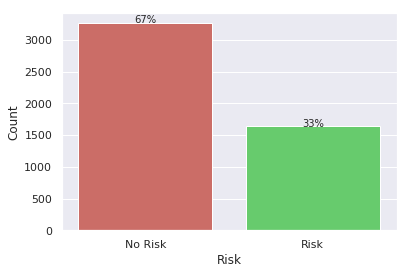

In [15]:
print(df.groupby([TARGET_LABEL_COLUMN_NAME]).size())
risk_plot = sns.countplot(data=df, x=TARGET_LABEL_COLUMN_NAME, order=df[TARGET_LABEL_COLUMN_NAME].value_counts().index)
plt.ylabel('Count')
for p in risk_plot.patches:
    height = p.get_height()
    risk_plot.text(p.get_x()+p.get_width()/2., height + 1,'{0:.0%}'.format(height/float(len(df))),ha="center") 
plt.show()

We can get use frequency counts charts to get an understanding of the categorical features relative to Risk

- We can see in the `CheckingStatus` visualization, loan applications with 'no_checking' have a higher occurence of Risk versus loans with other checking status values.
- We can see in the `CreditHistory` visualization, the loans that have no credits (i.e. all credit has been paid back) have no occurences of Risk (at least in this dataset). There is a small count of Risk for those applicants that have paid back all credit to date. And there is a higher frequency or ratio of Risk for applicants that have existing credit (i.e outstanding credit).

### NOTE: The creation of these plots can take several minutes

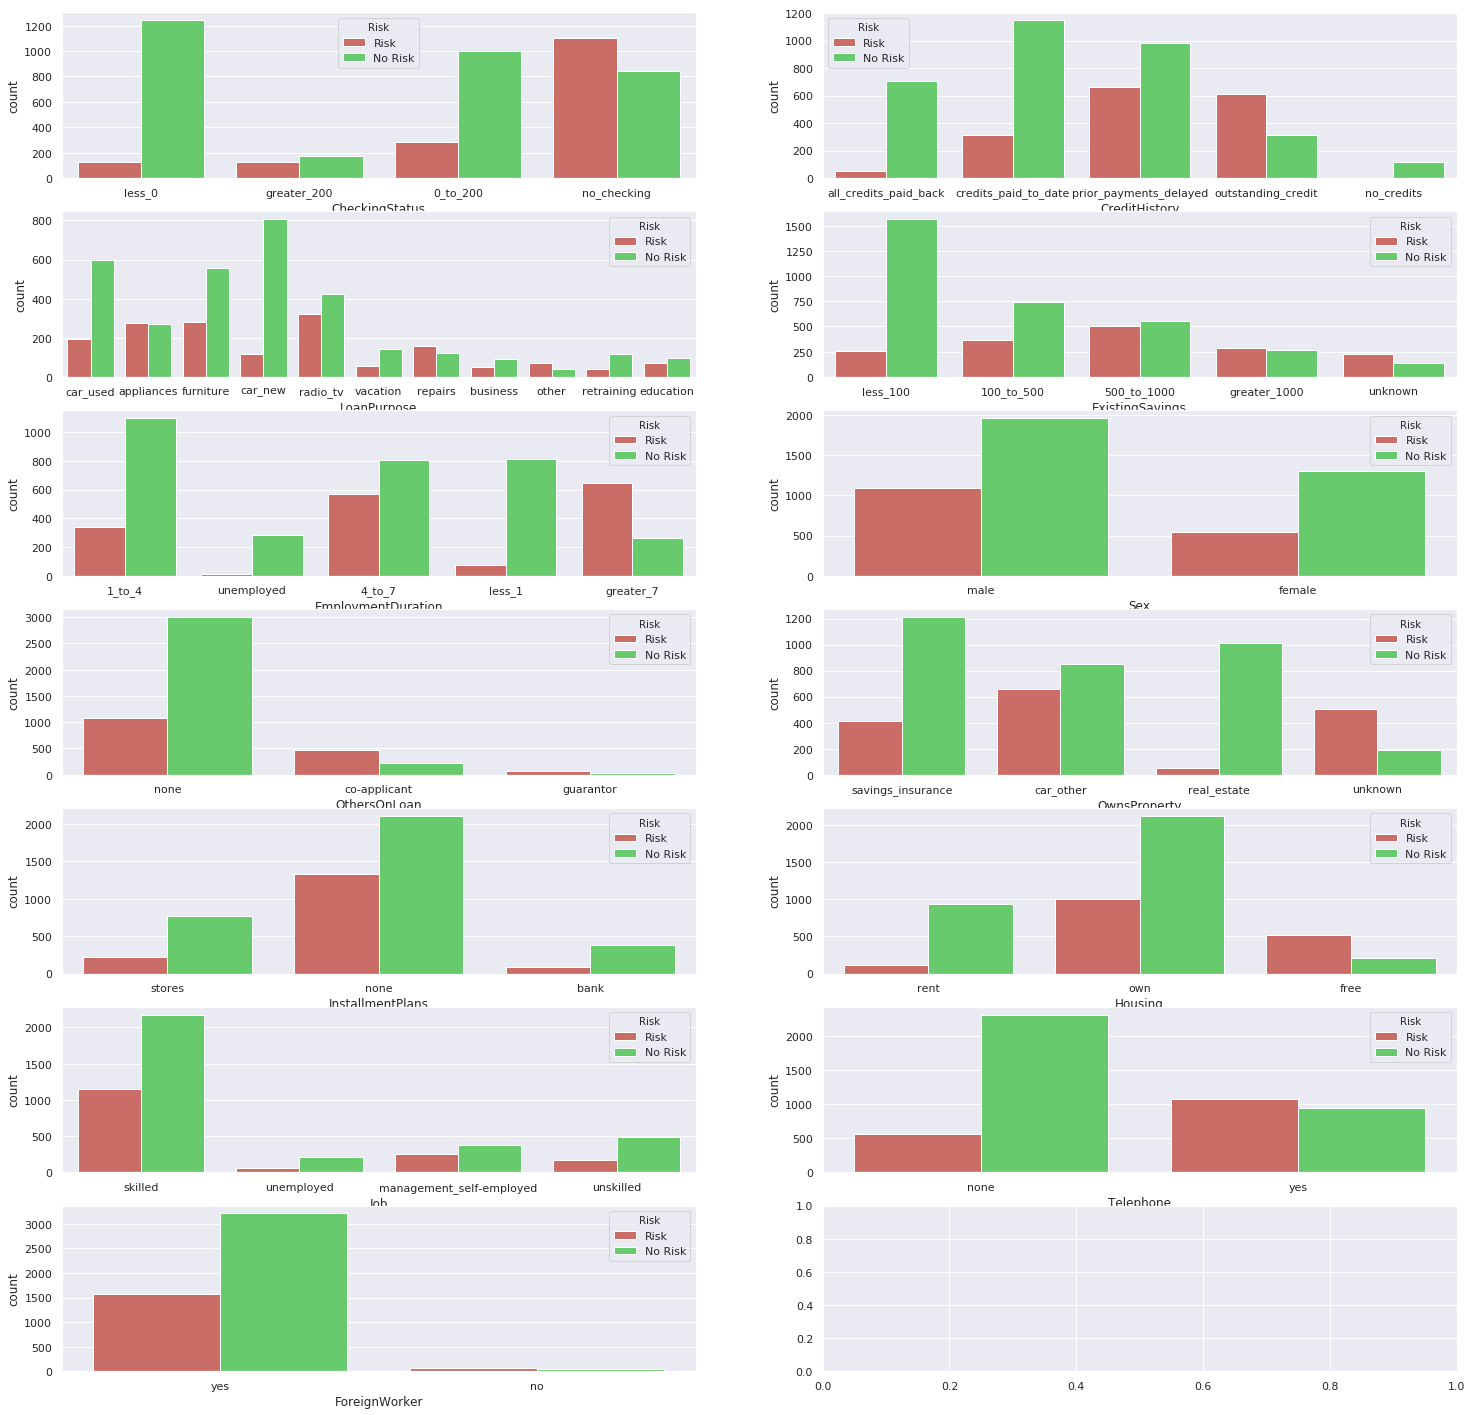

In [16]:
# Categorical feature count plots
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14)) = plt.subplots(7, 2, figsize=(25, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14 ]

for i in range(len(categorical_features)):
    sns.countplot(x = categorical_features[i], hue=TARGET_LABEL_COLUMN_NAME, data=df, ax=ax[i])
    

We can get use histrogram and boxplots to get an understanding of the distribution of our continuous / numerical features relative to Risk.

- We can see that for loans that have Risk, the `InstallmentPercent` tends to be higher (i.e. the loans with Risk tend to have loan amounts with higher percentage of the loan applicants disposable income).
- We can see that those with 'No Risk' seem to be those with fewer existing credit loans at the bank (`ExistingCreditCount`)


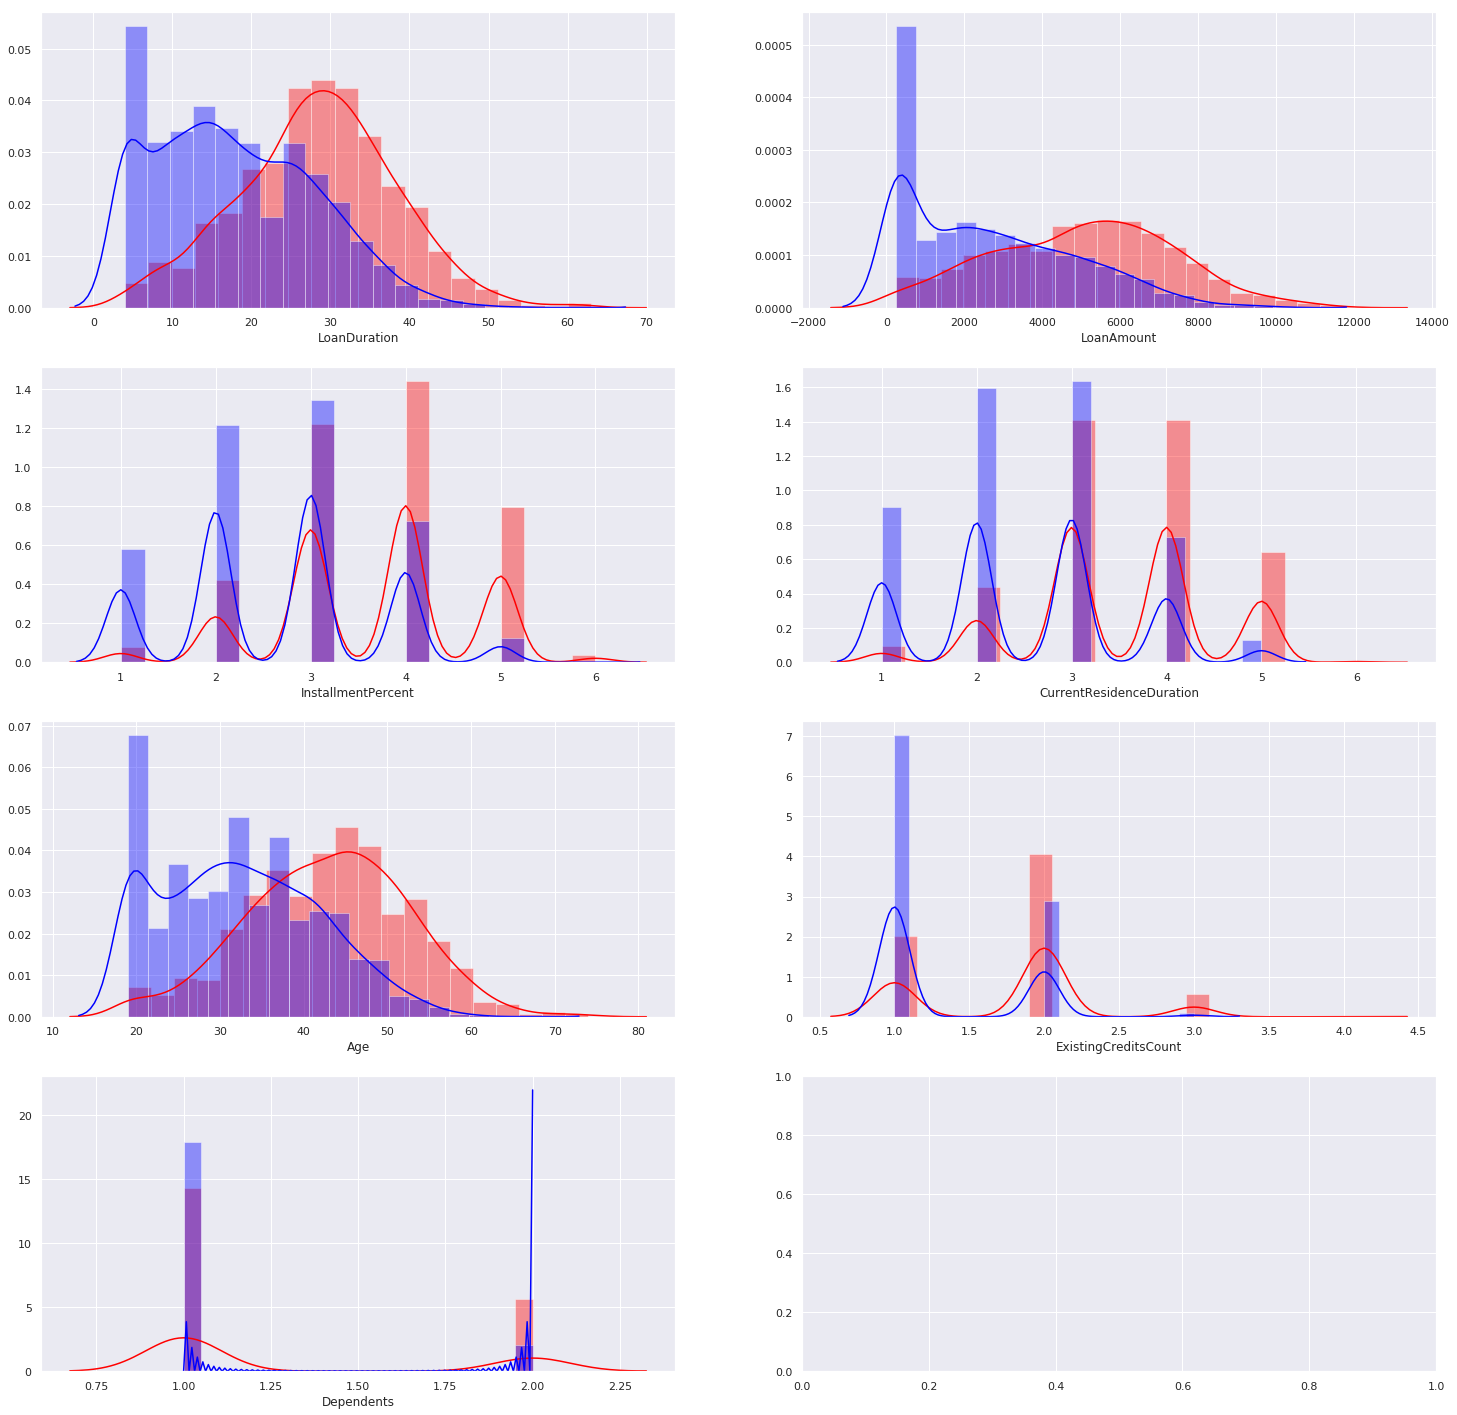

In [18]:
# Continuous feature histograms.
f, ((ax1, ax2),(ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(25, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(len(continuous_features)):
    #sns.distplot(df[continuous_features[i]], bins=20, color="blue", hist=True, ax=ax[i])
    sns.distplot(df[df.Risk == 'Risk'][continuous_features[i]], bins=20, color="Red", hist=True, ax=ax[i])
    sns.distplot(df[df.Risk == 'No Risk'][continuous_features[i]], bins=20, color="blue", hist=True, ax=ax[i])


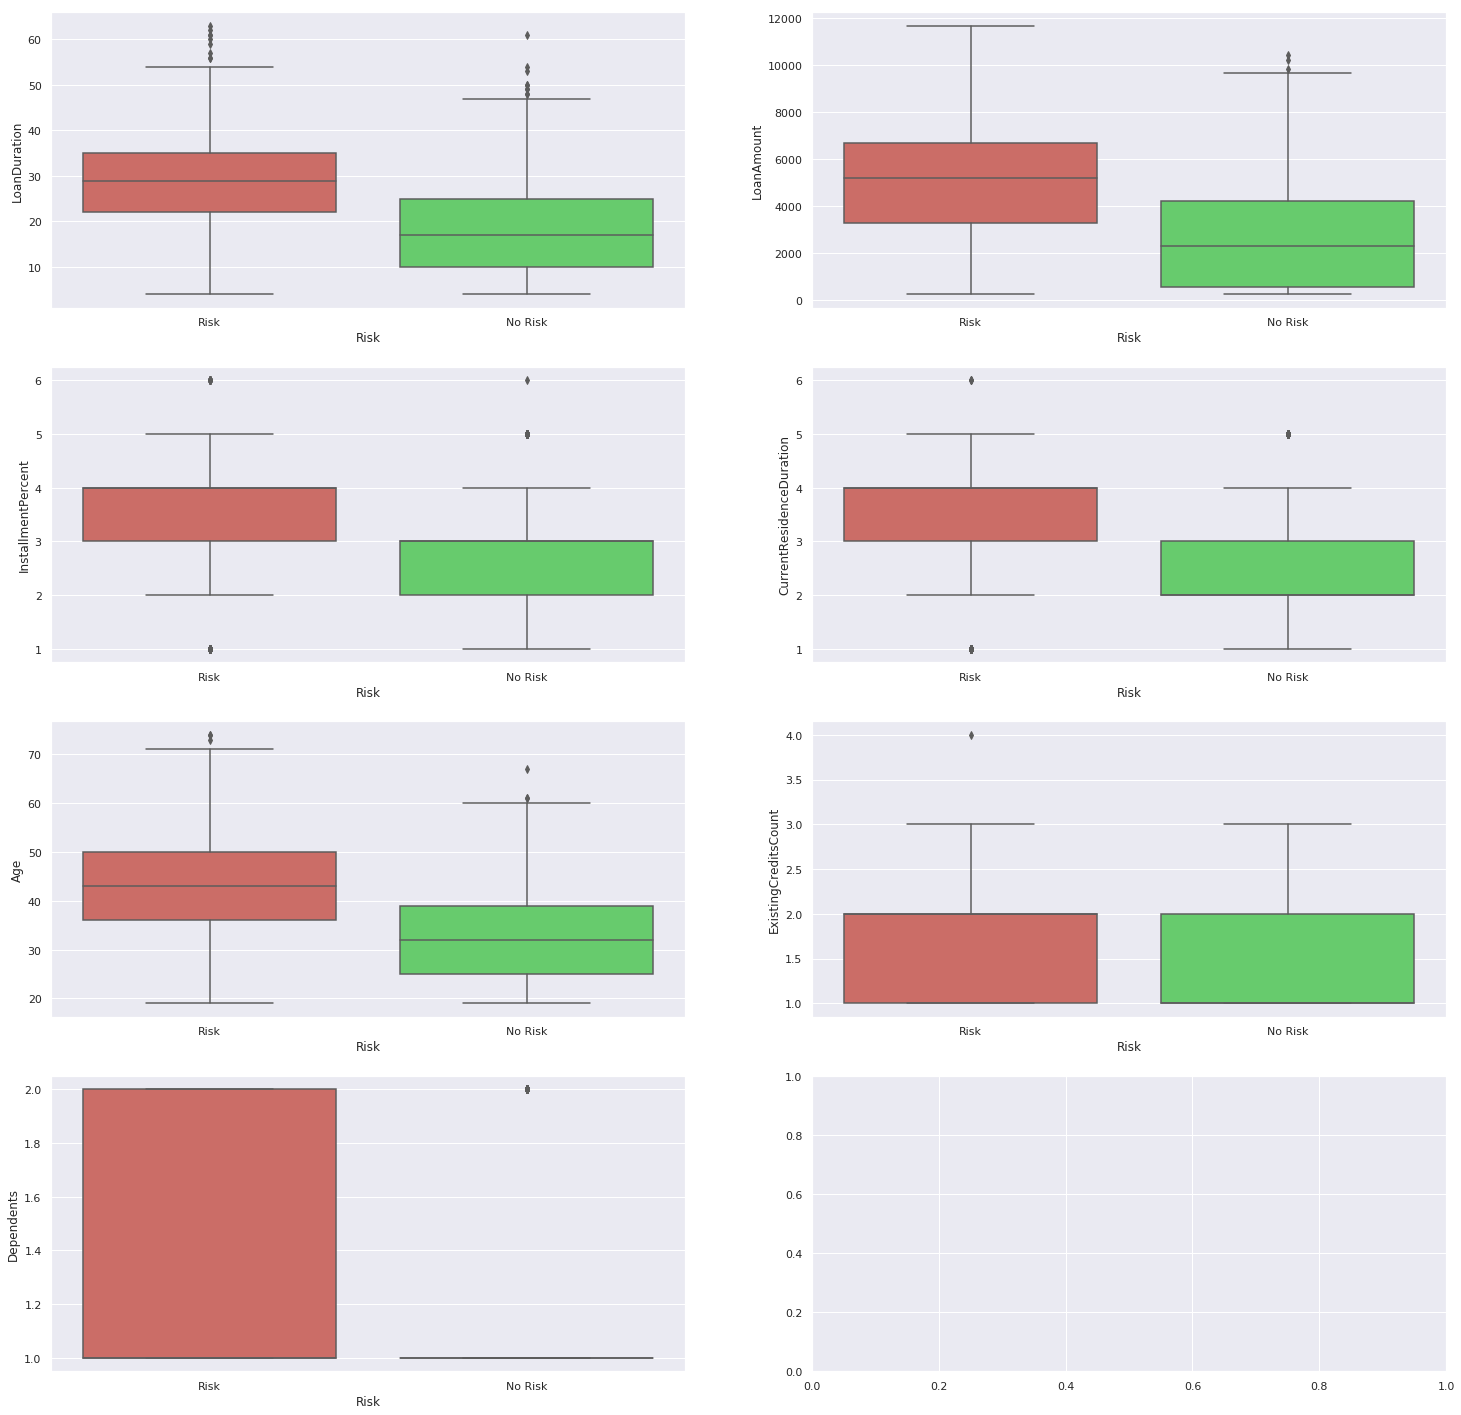

In [19]:
# Plot boxplots of numerical columns. More variation in the boxplot implies higher significance. 
f, ((ax1, ax2),(ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(25, 25))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
for i in range(len(continuous_features)):
    sns.boxplot(x = TARGET_LABEL_COLUMN_NAME, y = continuous_features[i], data=df, ax=ax[i])


## 3.0 Create a model

Now we can create our machine learning model. You could use the insights / intuition gained from the data visualization steps above to what kind of model to create or which features to use. We will create a simple classification model.

In [20]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
df_data = spark.createDataFrame(df)
df_data.head()

Row(CheckingStatus='less_0', LoanDuration=6, CreditHistory='all_credits_paid_back', LoanPurpose='car_used', LoanAmount=250, ExistingSavings='less_100', EmploymentDuration='1_to_4', InstallmentPercent=2, Sex='male', OthersOnLoan='none', CurrentResidenceDuration=2, OwnsProperty='savings_insurance', Age=28, InstallmentPlans='stores', Housing='rent', ExistingCreditsCount=1, Job='skilled', Dependents=1, Telephone='none', ForeignWorker='yes', Risk='Risk')

### 3.1 Split the data into training and test sets

In [21]:
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

Number of records for training: 3957
Number of records for evaluation: 943


### 3.2 Examine the Spark DataFrame Schema
Look at the data types to determine requirements for feature engineering

In [22]:
spark_df.printSchema()

root
 |-- CheckingStatus: string (nullable = true)
 |-- LoanDuration: long (nullable = true)
 |-- CreditHistory: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- LoanAmount: long (nullable = true)
 |-- ExistingSavings: string (nullable = true)
 |-- EmploymentDuration: string (nullable = true)
 |-- InstallmentPercent: long (nullable = true)
 |-- Sex: string (nullable = true)
 |-- OthersOnLoan: string (nullable = true)
 |-- CurrentResidenceDuration: long (nullable = true)
 |-- OwnsProperty: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- InstallmentPlans: string (nullable = true)
 |-- Housing: string (nullable = true)
 |-- ExistingCreditsCount: long (nullable = true)
 |-- Job: string (nullable = true)
 |-- Dependents: long (nullable = true)
 |-- Telephone: string (nullable = true)
 |-- ForeignWorker: string (nullable = true)
 |-- Risk: string (nullable = true)



### 3.3 Use StringIndexer to encode a string column of labels to a column of label indices

We are using the Pipeline package to build the development steps as pipeline. 
We are using StringIndexer to handle categorical / string features from the dataset. StringIndexer encodes a string column of labels to a column of label indices

We then use VectorAssembler to asemble these features into a vector. Pipelines API requires that input variables are passed in  a vector

In [23]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model

#Create StringIndexer columns whose names are same as the categorical column with an appended _IX.
categorical_num_features = [x + '_IX' for x in categorical_features]
si_list = [StringIndexer(inputCol=nm_in, outputCol=nm_out) for nm_in, nm_out in zip(categorical_features, categorical_num_features)]

In [24]:
# Encode our target label column (i.e Risk or No Risk). 
# Also, creates an label convert which performs an inverse map to get back a 'Risk' or 'No Risk' label from the encoded prediction.
si_label = StringIndexer(inputCol=TARGET_LABEL_COLUMN_NAME, outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_label.labels)

In [25]:
# Construct all encoded categorical features plus continuous features into a vector
va_features = VectorAssembler(inputCols=categorical_num_features + continuous_features, outputCol="features")

### 3.4 Create a pipeline, and fit a model using RandomForestClassifier 
Assemble all the stages into a pipeline. We don't expect a clean linear regression, so we'll use RandomForestClassifier to find the best decision tree for the data.

The pipeline will consist of: the feature string indexing step, the label string indexing Step, vector sssembly of all features step, random forest classifier, label converter step, and ending with a feature filter step.

**Note: If you want filter features from model output, you could use the feature filter by replacing `*` with feature names to be retained in SQLTransformer statement.**

In [26]:
classifier = RandomForestClassifier(featuresCol="features")
feature_filter = SQLTransformer(statement="SELECT * FROM __THIS__")
pipeline = Pipeline(stages= si_list + [si_label, va_features, classifier, label_converter, feature_filter])

model = pipeline.fit(train_data)

In [27]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderROC')
area_under_curve = evaluatorDT.evaluate(predictions)

evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderPR')
area_under_PR = evaluatorDT.evaluate(predictions)
#default evaluation is areaUnderROC
print("areaUnderROC = %g" % area_under_curve, "areaUnderPR = %g" % area_under_PR)

areaUnderROC = 0.726757 areaUnderPR = 0.634758


### 3.5 evaluate more metrics by exporting them into pandas and numpy

In [28]:
from sklearn.metrics import classification_report
y_pred = predictions.toPandas()['prediction']
print(y_pred)
y_pred = ['Risk' if pred == 1.0 else 'No Risk' for pred in y_pred]
print(y_pred)
y_test = test_data.toPandas()[TARGET_LABEL_COLUMN_NAME]
print(classification_report(y_test, y_pred, target_names=['Risk', 'No Risk']))

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6      0.0
7      0.0
8      0.0
9      0.0
10     0.0
11     0.0
12     0.0
13     0.0
14     0.0
15     0.0
16     0.0
17     0.0
18     0.0
19     0.0
20     0.0
21     0.0
22     0.0
23     0.0
24     0.0
25     0.0
26     0.0
27     0.0
28     0.0
29     0.0
      ... 
913    1.0
914    1.0
915    1.0
916    0.0
917    1.0
918    1.0
919    0.0
920    1.0
921    1.0
922    0.0
923    1.0
924    0.0
925    1.0
926    1.0
927    1.0
928    1.0
929    1.0
930    1.0
931    0.0
932    1.0
933    1.0
934    1.0
935    1.0
936    1.0
937    1.0
938    1.0
939    1.0
940    1.0
941    0.0
942    1.0
Name: prediction, Length: 943, dtype: float64
['No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Ris

              precision    recall  f1-score   support

        Risk       0.81      0.90      0.85       637
     No Risk       0.72      0.56      0.63       306

   micro avg       0.79      0.79      0.79       943
   macro avg       0.77      0.73      0.74       943
weighted avg       0.78      0.79      0.78       943



In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[572,  65],
       [136, 170]])

## 4.0 Create and export data set to Cognos Analytics

We will use our model to score some new credit applications.
We will then take the results of our model scoring, export it to Cognos Analytics where we can create some new visualizations.

In [30]:
# Use our CA Data Connector to access the new credit applications stored in Cognos Analytics.
# In order to access the data, modify the following line by changing the path and filename to match your data asset in CA.
# NOTE: the file name should be similar to "german_credit_new_apps_data.csv".
df_new = CADataConnector.read_data(path=".public_folders/cognos-studio-data/german_credit_new_apps_data.csv")
df_new.head(5)

,CustomerID,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,...,CurrentResidenceDuration,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker
0,713a336c-a255-4e2d-9d57-90b3e99e2f06,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,...,3,savings_insurance,32,none,own,1,skilled,1,none,yes
1,140b363f-a3fe-4828-a33f-7284dfdb3969,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,...,2,savings_insurance,37,stores,own,2,skilled,1,none,yes
2,43b7b51d-5eda-4860-b461-ebef3d3436f4,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,...,3,real_estate,28,none,own,2,skilled,1,yes,no
3,f40eaf08-e6d1-4765-ab20-c5f7faca1635,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,...,2,savings_insurance,32,none,own,1,skilled,1,none,yes
4,1728910a-d3ff-4799-ac50-203a3a58a3fb,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,...,3,unknown,57,none,own,2,skilled,1,none,yes


In [31]:
# create a Spark dataframe
df_data_new = spark.createDataFrame(df_new)

# score the data using our model
predictions = model.transform(df_data_new)

# convert risk to string
y_pred = predictions.toPandas()['prediction']
y_pred = ['Risk' if pred == 1.0 else 'No Risk' for pred in y_pred]
print(y_pred)

['No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'No Risk', 'No Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'No Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'No Risk', 'Risk', 'Risk', 'No Risk', 'Risk', 'Risk', 'No Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'No Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'Risk', 'Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk', 'No Risk', 'No Risk', 'No Risk', 'No Ris

In [32]:
# create a new data frame from our new credit applications data frame, but only keep the CustomerID column 
df_new_scored = df_new
df_new_scored = df_new_scored.drop(columns=['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker'], axis=1, errors='ignore')

# now add in a new column named PREDICTED_RISK and assign the risks generated from the model
df_new_scored['PredictedRisk'] = y_pred
print(df_new_scored)

                              CustomerID PredictedRisk
0   713a336c-a255-4e2d-9d57-90b3e99e2f06       No Risk
1   140b363f-a3fe-4828-a33f-7284dfdb3969       No Risk
2   43b7b51d-5eda-4860-b461-ebef3d3436f4       No Risk
3   f40eaf08-e6d1-4765-ab20-c5f7faca1635       No Risk
4   1728910a-d3ff-4799-ac50-203a3a58a3fb          Risk
5   a7a23fbe-fb18-4ed5-97df-883d142ab60a          Risk
6   74ad5d1c-ac0e-4535-96ac-43dc742dce36       No Risk
7   488bf81f-8909-446b-a1a8-9f03256ffd0e       No Risk
8   ba4198ab-ebf8-4e0a-b391-53ad5c77fca5       No Risk
9   83e5370a-09f1-4c9c-84c9-6660be9da9ec          Risk
10  5ff1b18e-e21b-4e93-847b-85cbb8f44e08       No Risk
11  ab8078d3-4bb6-463d-a6a6-b8fd79f8ba46       No Risk
12  1e781d31-4b68-48ed-94a8-eb869afb5bfe          Risk
13  129270cc-e4ef-4849-9d9f-7be5639c02fc       No Risk
14  c55c1313-4df7-4f46-89fd-e5a55e31dc8a       No Risk
15  111ea0f0-2f70-4f38-9a84-7670ced62c90       No Risk
16  f8710ab9-c082-4aac-9103-f7be0dd51832       No Risk
17  893a28

In [34]:
# Write the new data frame back out to Cognos Analytics
# Update the path to match your Cognos Analytics folder
CADataConnector.write_data(df_new_scored, path=".public_folders/cognos-studio-data/german_credit_new_apps_scored.csv")

Congratulations!

The new scored data should now be located in your Cognos Analytics data folder.
Return to your Cognos Analytics dashboard and start creating some visualizations.